In [23]:
import importlib
from matplotlib import pyplot as plt 


import calibration_metric
from calibration_metric.vis.calibration_plot import plot_df, get_df_from_file
from calibration_metric.utils.reader import TopLogitFormatSequenceReader
from calibration_metric import ECEMetric
importlib.reload(calibration_metric)

spider_paths_and_models = [
                            # ("/brtx/604-nvme2/estengel/calflow_calibration/benchclamp/1.0/t5-small-lm-adapt_spider_past_none_db_val_all_0.0001/checkpoint-10000//outputs/test_all.logits",
                            # "T5-small"),
                            ("/brtx/604-nvme2/estengel/calflow_calibration/benchclamp/1.0/t5-base-lm-adapt_spider_past_none_db_val_all_0.0001/checkpoint-10000//outputs/test_all.logits",
                            "T5-base"),
                            ("/brtx/604-nvme2/estengel/calflow_calibration/benchclamp/1.0/t5-large-lm-adapt_spider_past_none_db_val_all_0.0001/checkpoint-10000/outputs/test_all.logits", 
                             "T5-large"),
                            ("/brtx/604-nvme2/estengel/calflow_calibration/benchclamp/1.0/bart-base_spider_past_none_db_val_all_0.0001/checkpoint-5000/outputs/test_all.logits",
                            "BART-base"),
                            ("/brtx/604-nvme2/estengel/calflow_calibration/benchclamp/1.0/bart-large_spider_past_none_db_val_all_0.0001/checkpoint-5000/outputs/test_all.logits",
                            "BART-large"),
                            ("/brtx/604-nvme2/estengel/calflow_calibration/benchclamp/1.0/codet5-base_spider_past_none_db_val_all_0.0001/checkpoint-10000/outputs/test_all.logits",
                            "Code-T5-base")]


all_dfs = {"spider": {}, "cosql": {}}

print("get spider dfs")
for path, name in spider_paths_and_models:
    try:
        # df, ece = get_df_from_file(path, n_bins=10) 
        df, ece = get_df_from_file(path, n_bins=10, binning_strategy="adaptive", ignore_tokens=['"', "'"])
        all_dfs['spider'][name] = (df, ece)
    except FileNotFoundError:
        print(f"missing: {name}")
        continue

get spider dfs


In [24]:
import json
import numpy as np


class PPLTopLogitFormatSequenceReader(TopLogitFormatSequenceReader):

    def read(self):
        """
        Read the file and extract the single top predicted index
        and the corresponding confidence score (logit).
        Compares each predicted index to the label index to determine
        whether the prediction was correct.
        Returns:
            top_preds: np.array of shape (num_examples, )
            logit_at_label: np.array of shape (num_examples, )
            is_correct: np.array of shape (num_examples, )
        """
        all_top_preds = []
        all_is_correct = []
        all_logit_at_label = []
        with open(self.file, 'r') as f:
            for line in f:
                line = json.loads(line)
                top_k_logits = np.array(line['top_logits'])
                top_k_logit_idxs = np.array(line['top_logit_idxs'])
                # get the top 1 logit and idx
                top_one_logit_local_idx = np.argmax(top_k_logits, axis=-1)
                seq_len = top_one_logit_local_idx.shape
                logit_at_label = np.array(line['logit_at_label'])
                if len(seq_len) > 1: 
                    # TODO: implement batched version
                    raise NotImplementedError(f"Currently batched outputs are not supported.\
                         Try generating outputs a single example at a time.")

                seq_len = seq_len[0]

                # get the actual single top logit, not assuming they're sorted already 
                top_one_logit_local_idx = top_one_logit_local_idx.reshape((seq_len, 1))
                top_one_logit = np.take_along_axis(top_k_logits, top_one_logit_local_idx, axis=1)
                top_one_logit_idx = np.take_along_axis(top_k_logit_idxs, top_one_logit_local_idx, axis=1)
                labels = np.array(line['labels'])

                # currently only support single example per line 
                top_logits = top_one_logit.reshape(-1)
                top_logit_idxs = top_one_logit_idx.reshape(-1)

                is_correct = self.check_tokens(top_logit_idxs, labels) 

                for timestep in range(top_logits.shape[0]):
                    # ignore tokens if specified
                    # meant to be tokens like @ROOT@, BOS, EOS, etc.
                    if self.ignore_tokens is not None and labels[timestep] in self.ignore_tokens:
                        continue
                    all_top_preds.append(top_logits[timestep])
                    all_is_correct.append(is_correct[timestep])
                    all_logit_at_label.append(logit_at_label[timestep])

        return (np.array(all_top_preds), np.array(all_logit_at_label), np.array(all_is_correct))

In [25]:
from collections import defaultdict 

ece_metric = ECEMetric(n_bins=20, binning_strategy="adaptive")
def get_ppl_by_bin(path):
    reader = PPLTopLogitFormatSequenceReader(path)
    top_preds, label_logits, correct = reader.read() 


    (values, 
    bins, 
    bin_numbers) = ece_metric.adaptive_bin(top_preds, correct)

    # get average ppl per bin 
    log_logits_by_bin = defaultdict(list)
    for logit, bin_number in zip(label_logits, bin_numbers):

        log_logits_by_bin[bin_number].append(np.log(logit))
    ppl_by_bin = {}
    for bin_number, log_logits in log_logits_by_bin.items():
        ppl_by_bin[bin_number] = np.exp(-np.mean(log_logits))
    
    ppls = [ppl_by_bin[i] for i in range(len(bins))]
    return  values, bins, ppls





In [26]:
import pandas as pd
all_df = []

for path, model in spider_paths_and_models:

    values, bins, ppls = get_ppl_by_bin(path) 
    for v, b, p in zip(values, bins, ppls):
        all_df.append({"model": model, "prob_correct": v, "prob_model": b, "ppl": p})

spider_df = pd.DataFrame(all_df)

spider_df['bin_ece'] = spider_df['prob_model'] - spider_df['prob_correct']
spider_df['bin_ece'] = spider_df['bin_ece'].abs()

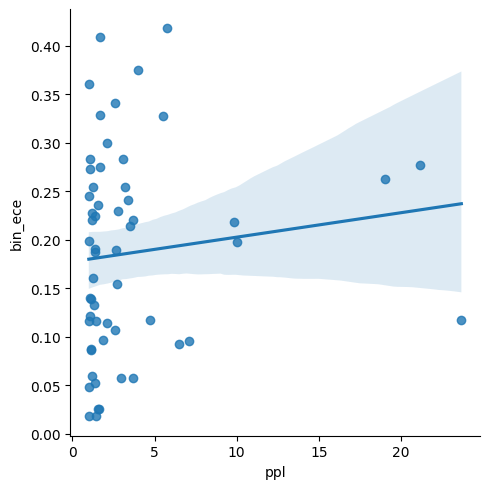

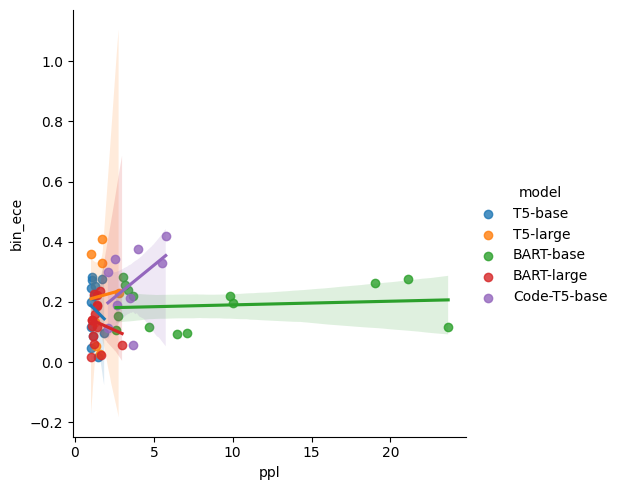

In [27]:
from matplotlib import pyplot as plt
import seaborn as sns

sns.lmplot(data = spider_df, x="ppl", y="bin_ece", scatter=True)
sns.lmplot(data = spider_df, x="ppl", y="bin_ece", hue="model", scatter=True)